# Australia rain prediction
**by Bartosz Pijet & Jan Makowiecki**

Biologically Inspired Artificial Intelligence - project

## Data preparation

In [178]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks
from scipy import stats

np.random.seed(0)

In [179]:
data = pd.read_csv("weatherAUS.csv")
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


**About the data:**

The dataset contains about 10 years of daily weather observations from different locations across Australia. Observations were drawn from numerous weather stations. 

In this project, I will use this data to predict whether or not it will rain the next day. There are 23 attributes including the target variable "RainTomorrow", indicating whether or not it will rain the next day or not. 

In [180]:
data.info()
records_cnt_start = len(data.index)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

## DATA VISUALIZATION AND CLEANING

**Removal of missing output values**

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

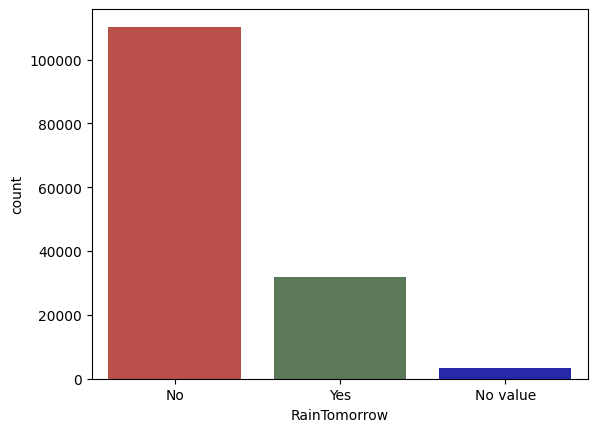

In [181]:
# first of all let us evaluate the target and find out if our data is imbalanced or not
colors = ["#CC4137","#567D54", '#1212C0']
sns.countplot(x= data["RainTomorrow"].fillna("No value"), palette= colors)

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

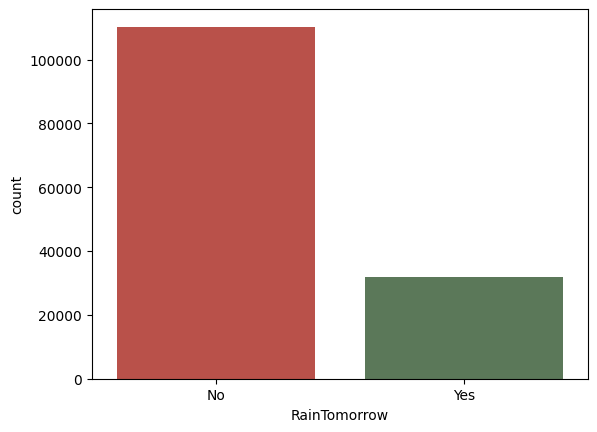

In [182]:
# we should remove rows with missing RainTomorrow values, because we shouldn't guess the result
data = data[data['RainTomorrow'].notna()]
colors= ["#CC4137","#567D54", '#1212E0']
sns.countplot(x= data["RainTomorrow"], palette= colors)

<AxesSubplot:>

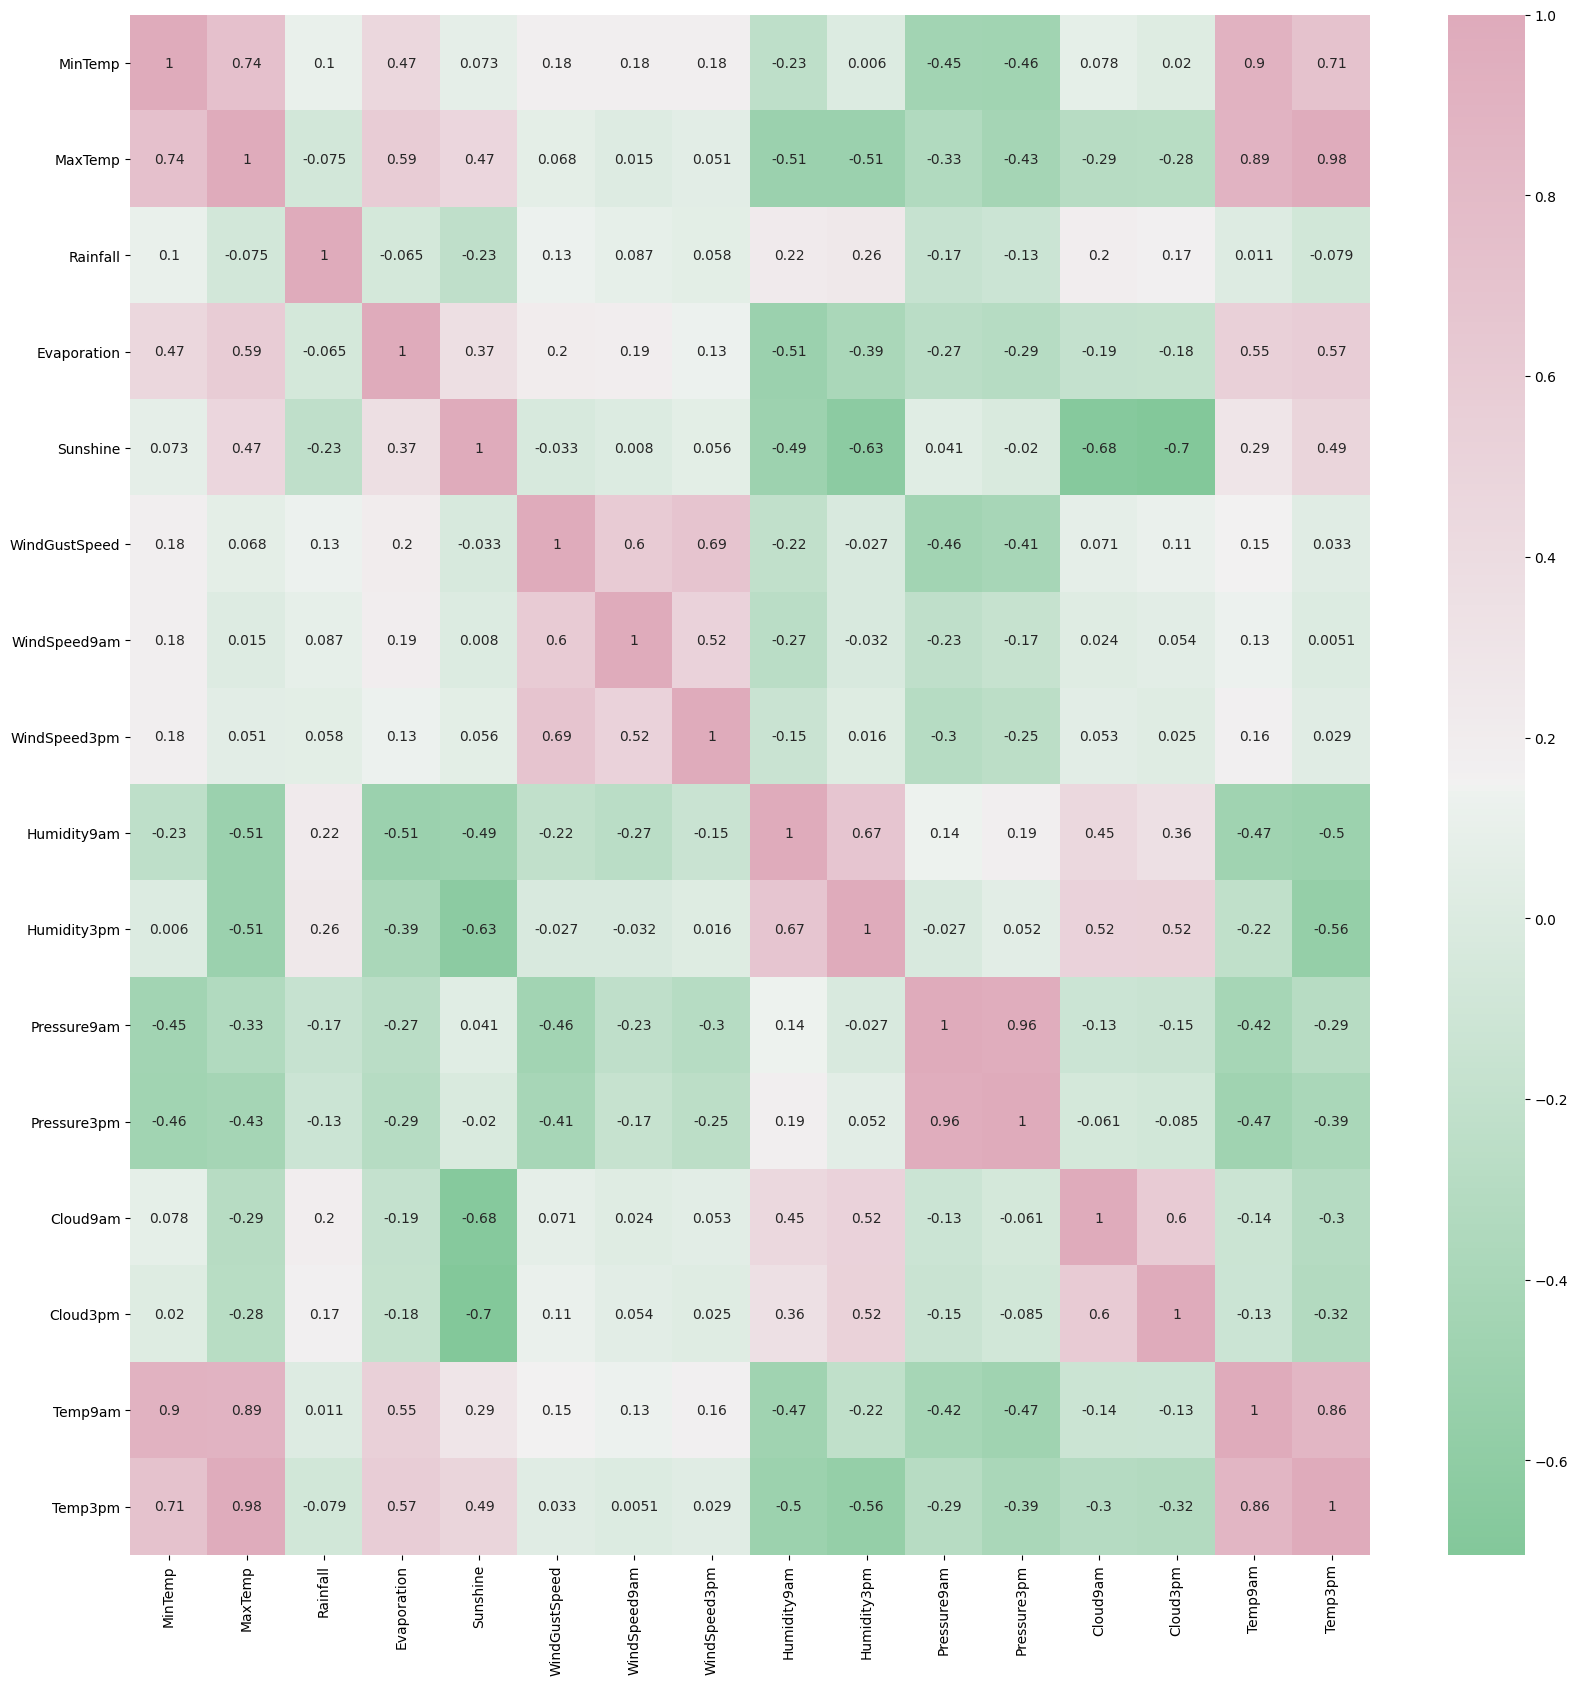

In [183]:
# Correlation amongst numeric attributes
corrmat = data.corr()
cmap = sns.diverging_palette(500,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(20,20))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=False)

**Parsing date data in a cyclical manner**

In [184]:
# helper function to create columns for sin and cos
def encode(data, col, max_val):
    data[col + '_sin'] = (np.sin(2 * np.pi * data[col]/max_val) + 1) / 2
    data[col + '_cos'] = (np.cos(2 * np.pi * data[col]/max_val) + 1) / 2
    return data

# changing 'Date' into datetime and splitting it into few columns
data['Date']= pd.to_datetime(data["Date"])

data['year'] = data.Date.dt.year

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

# removing helper columns
data = data.drop(columns=[
    'Date',
    'month',
    'day'
])


Text(0.5, 0, 'Sine Encoded Months')

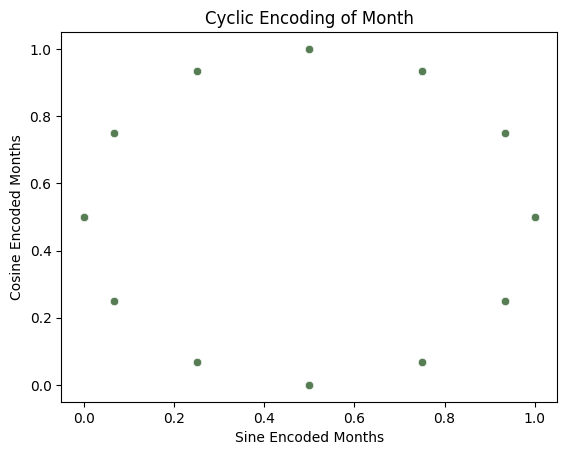

In [185]:
# cyclic relation between months
cyclic_month = sns.scatterplot(x="month_sin",y="month_cos",data=data, color="#567D54")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

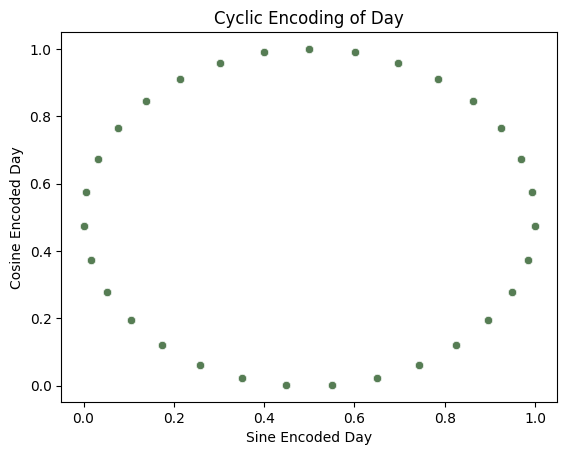

In [186]:
# cyclic relation between days
cyclic_day = sns.scatterplot(x='day_sin',y='day_cos',data=data, color="#567D54")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

**Filling missing categorical values with mode of the column value**

In [187]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [188]:
# Missing values in categorical variables
for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 9330
WindDir9am 10013
WindDir3pm 3778
RainToday 1406
RainTomorrow 0


In [189]:
# Filling missing values with mode of the column in value
for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

**Filling missing numerical values with median of the column value**

In [190]:
# Get list of neumeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Numeric variables:")
print(num_cols)

Numeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [191]:
# Missing values in numeric variables
for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 637
MaxTemp 322
Rainfall 1406
Evaporation 60843
Sunshine 67816
WindGustSpeed 9270
WindSpeed9am 1348
WindSpeed3pm 2630
Humidity9am 1774
Humidity3pm 3610
Pressure9am 14014
Pressure3pm 13981
Cloud9am 53657
Cloud3pm 57094
Temp9am 904
Temp3pm 2726
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [192]:
# Filling missing values with median of the column in value
for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)

In [193]:
data.info()
records_cnt_cleaning = len(data.index)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        142193 non-null  float64
 2   MaxTemp        142193 non-null  float64
 3   Rainfall       142193 non-null  float64
 4   Evaporation    142193 non-null  float64
 5   Sunshine       142193 non-null  float64
 6   WindGustDir    142193 non-null  object 
 7   WindGustSpeed  142193 non-null  float64
 8   WindDir9am     142193 non-null  object 
 9   WindDir3pm     142193 non-null  object 
 10  WindSpeed9am   142193 non-null  float64
 11  WindSpeed3pm   142193 non-null  float64
 12  Humidity9am    142193 non-null  float64
 13  Humidity3pm    142193 non-null  float64
 14  Pressure9am    142193 non-null  float64
 15  Pressure3pm    142193 non-null  float64
 16  Cloud9am       142193 non-null  float64
 17  Cloud3pm       142193 non-nul

Text(0.5, 0, 'Years')

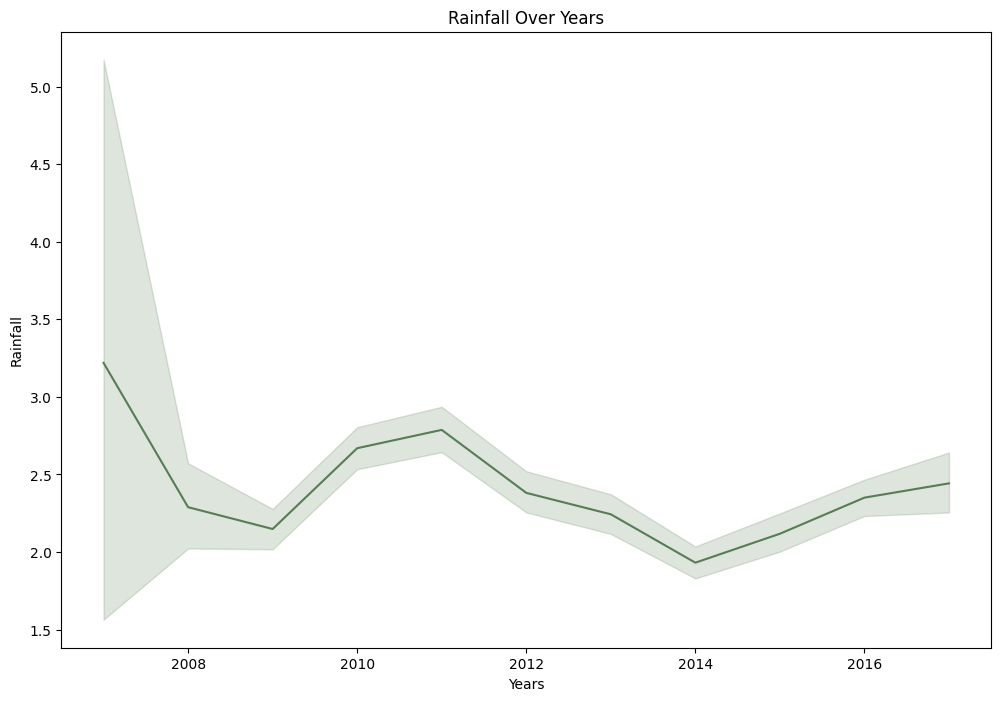

In [194]:
# plotting a lineplot rainfall over years
plt.figure(figsize=(12,8))
Time_series=sns.lineplot(x=data['year'],y="Rainfall",data=data,color="#567D54")
Time_series.set_title("Rainfall Over Years")
Time_series.set_ylabel("Rainfall")
Time_series.set_xlabel("Years")

Text(0.5, 0, 'Year')

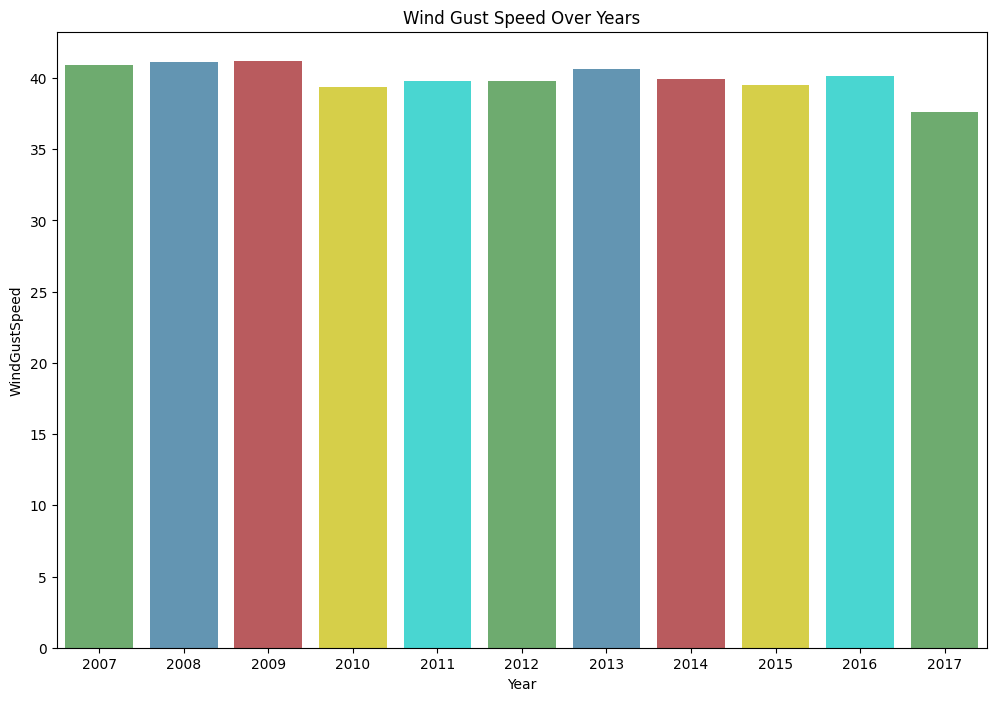

In [195]:
# Evaluating Wind gust speed over years
colours = ["#64b565", "#5699bf", "#c94b4f", "#ede432", "#32ede7"]
plt.figure(figsize=(12,8))
Days_of_week=sns.barplot(x=data['year'],y="WindGustSpeed",data=data, ci =None,palette = colours)
Days_of_week.set_title("Wind Gust Speed Over Years")
Days_of_week.set_ylabel("WindGustSpeed")
Days_of_week.set_xlabel("Year")

## Data preprocessing

**Label encoding for categorical data**

In [196]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])
    
data.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month_sin,month_cos,day_sin,day_cos
0,2,13.4,22.9,0.6,4.8,8.5,13,44.0,13,14,...,5.0,16.9,21.8,0,0,2008,0.5,1.0,0.600649,0.989765
1,2,7.4,25.1,0.0,4.8,8.5,14,44.0,6,15,...,5.0,17.2,24.3,0,0,2008,0.5,1.0,0.697178,0.959479
2,2,12.9,25.7,0.0,4.8,8.5,15,46.0,13,15,...,2.0,21.0,23.2,0,0,2008,0.5,1.0,0.785634,0.910382
3,2,9.2,28.0,0.0,4.8,8.5,4,24.0,9,0,...,5.0,18.1,26.5,0,0,2008,0.5,1.0,0.862396,0.844483
4,2,17.5,32.3,1.0,4.8,8.5,13,41.0,1,7,...,8.0,17.8,29.7,0,0,2008,0.5,1.0,0.924322,0.764482


**Detecting and removing outliers**

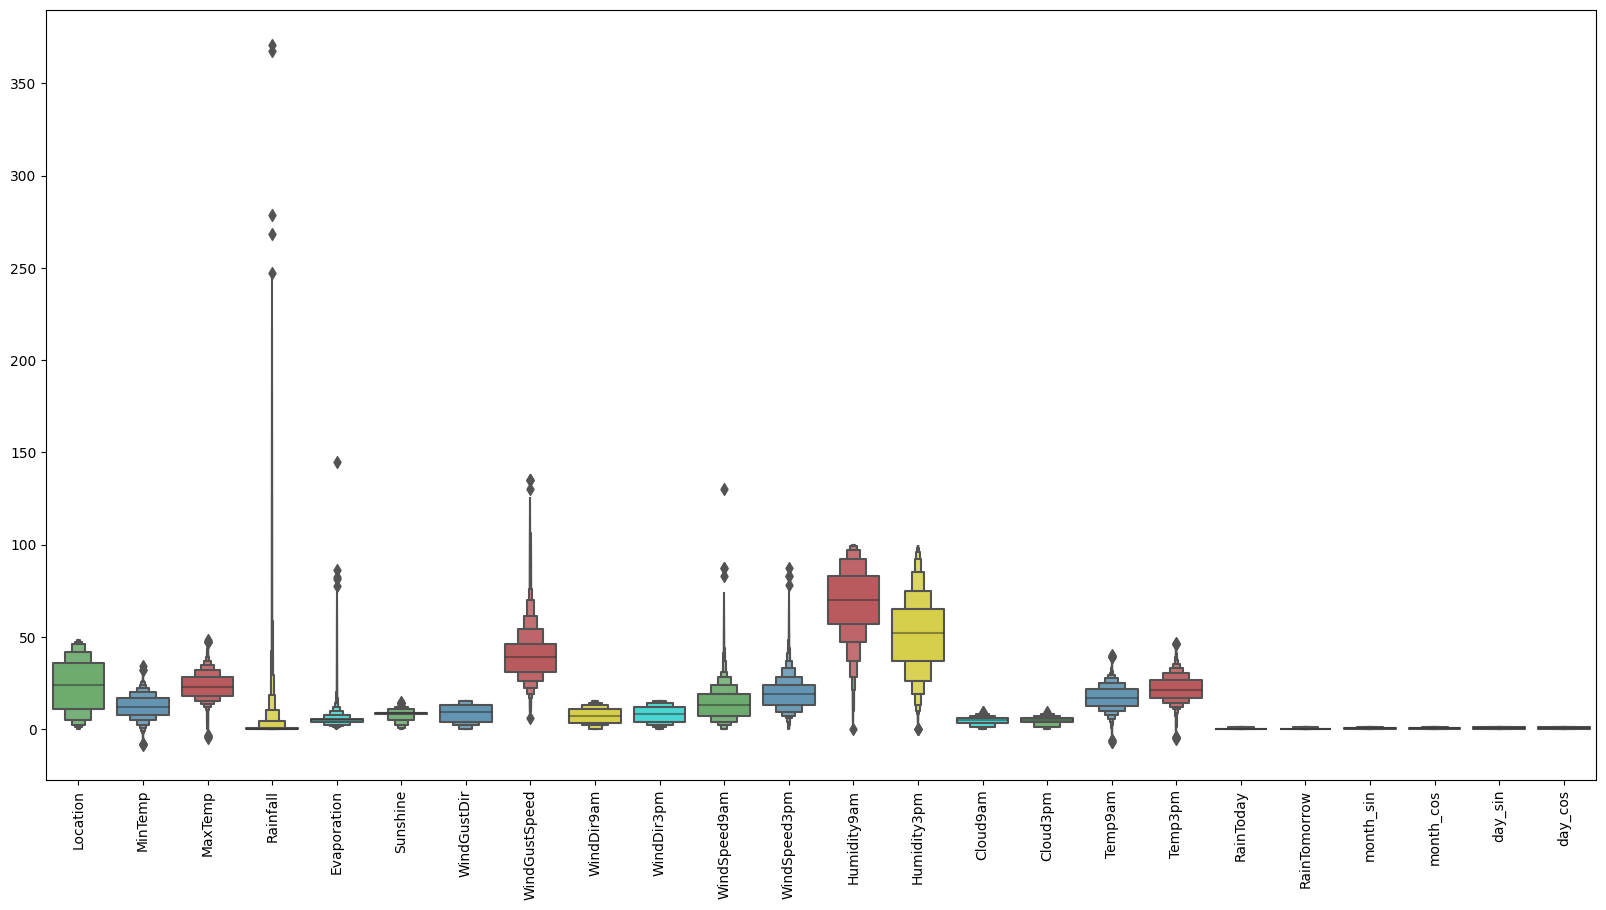

In [197]:
# Box plot of data in each column except year
colours = ["#64b565", "#5699bf", "#c94b4f", "#ede432", "#32ede7"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = data.drop(columns=['year', 'Pressure9am', 'Pressure3pm']),palette = colours)
plt.xticks(rotation=90)
plt.show()

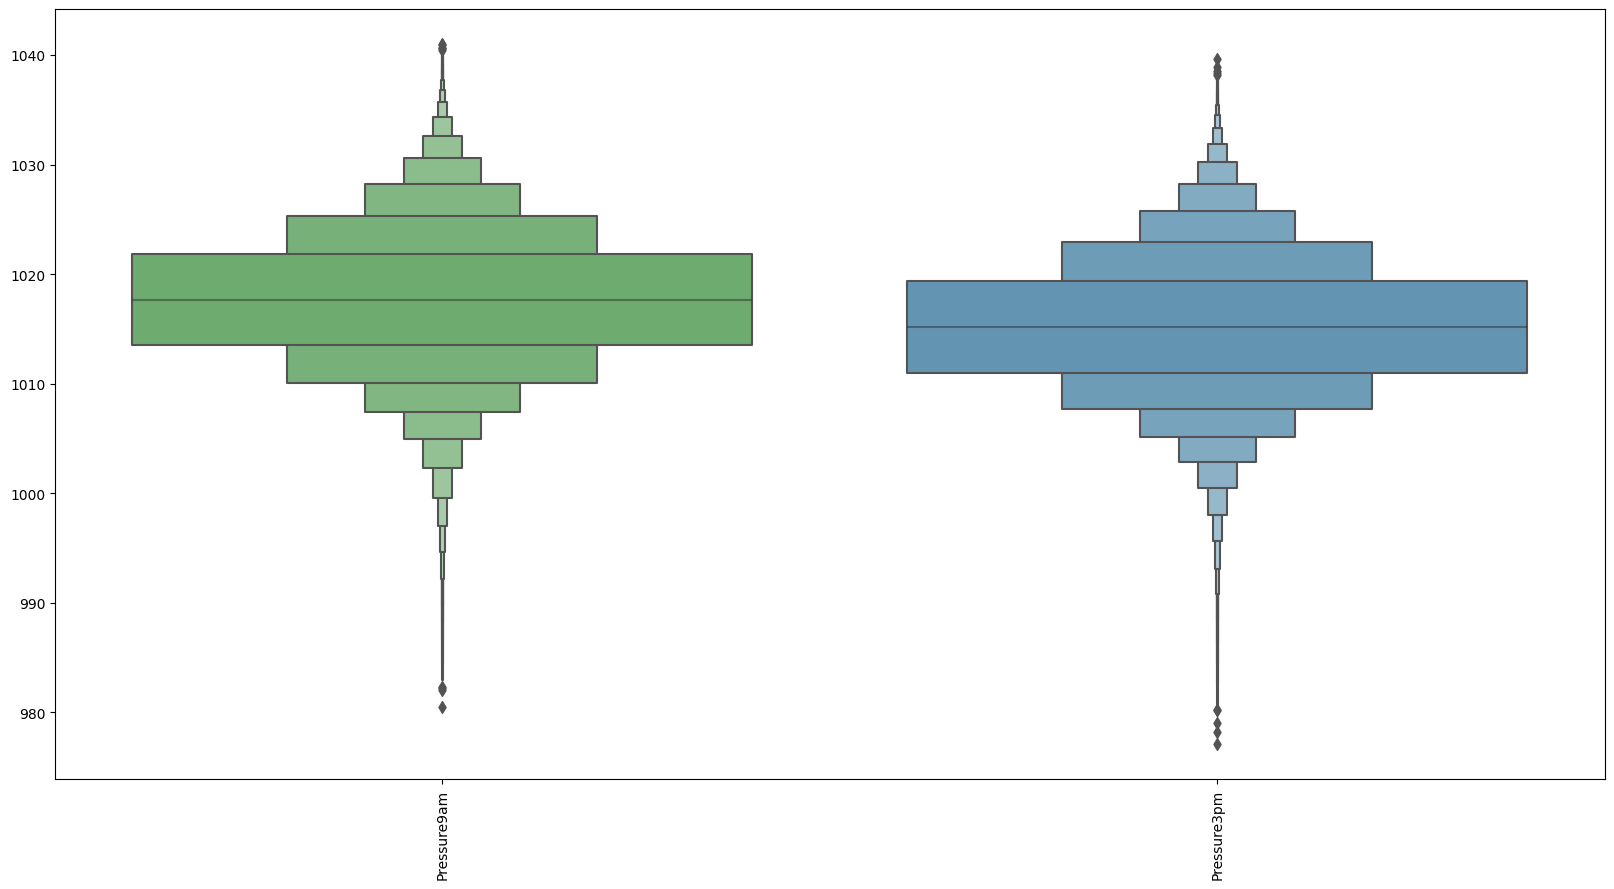

In [198]:
colours = ["#64b565", "#5699bf", "#c94b4f", "#ede432", "#32ede7"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = data.filter(['Pressure9am', 'Pressure3pm']),palette = colours)
plt.xticks(rotation=90)
plt.show()

In [199]:
data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
records_cnt_outliers = len(data.index)

**Normalization of all columns in a scale from -1 to 1**

In [200]:
scaled_col_names = ['RainToday', 'RainTomorrow', 'month_sin', 'month_cos', 'day_sin', 'day_cos']

# Prepairing attributes to scale data
to_normalize_col_names = [column for column in data.columns 
                if column not in scaled_col_names]


# Set up a min-max scaler for the features
min_max_scaler = preprocessing.MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(data.filter(to_normalize_col_names))

# Merge data back into one dataframe
all_data = pd.concat([
    pd.DataFrame(normalized_data, columns=to_normalize_col_names).reset_index(drop=True),
    data.filter(scaled_col_names).reset_index(drop=True)
], axis=1)


features = all_data.drop('RainTomorrow', axis=1)
target = all_data['RainTomorrow']


records_cnt_final = len(all_data.index)
all_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,133488.0,0.493838,0.295685,0.000000,0.229167,0.500000,0.750000,1.000000
MinTemp,133488.0,0.499536,0.166744,0.000000,0.379947,0.496042,0.620053,1.000000
MaxTemp,133488.0,0.498954,0.161498,0.000000,0.377934,0.485915,0.612676,1.000000
Rainfall,133488.0,0.052522,0.138908,0.000000,0.000000,0.000000,0.021739,1.000000
Evaporation,133488.0,0.336232,0.159137,0.000000,0.272109,0.326531,0.353741,1.000000
Sunshine,133488.0,0.556726,0.188101,0.000000,0.572414,0.586207,0.606897,1.000000
WindGustDir,133488.0,0.535004,0.313353,0.000000,0.266667,0.600000,0.866667,1.000000
WindGustSpeed,133488.0,0.455605,0.162899,0.000000,0.347222,0.458333,0.555556,1.000000
WindDir9am,133488.0,0.465458,0.301237,0.000000,0.200000,0.466667,0.733333,1.000000
WindDir3pm,133488.0,0.516225,0.303338,0.000000,0.266667,0.533333,0.800000,1.000000


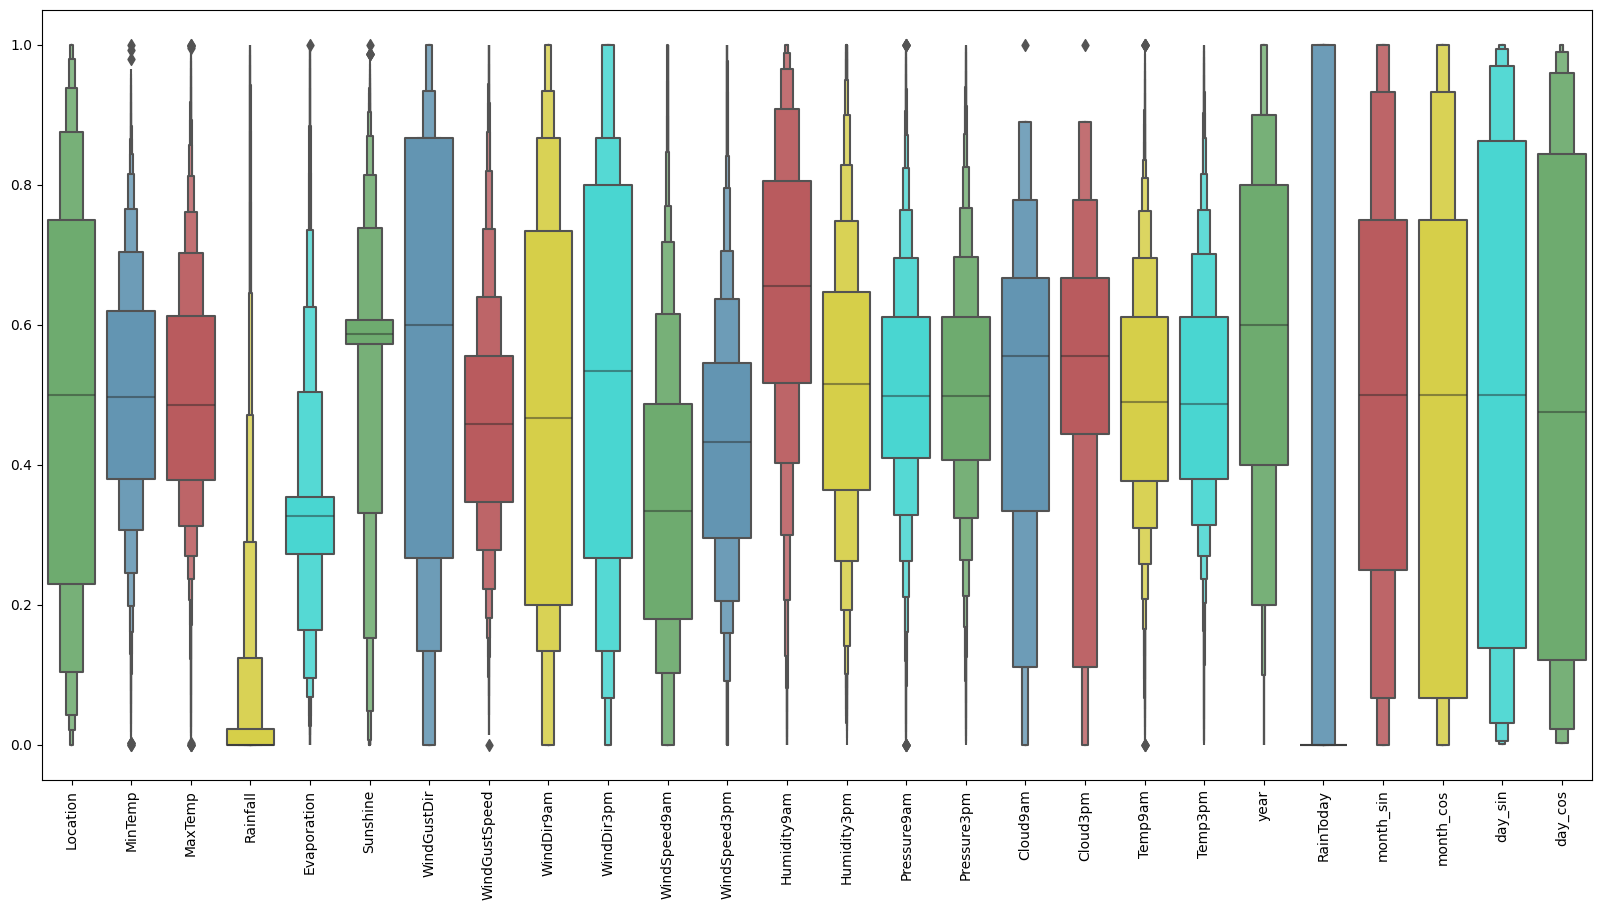

In [201]:
# cleaned and normalized data
colours = ["#64b565", "#5699bf", "#c94b4f", "#ede432", "#32ede7"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [202]:
print("Record count:")
print("Start: ", records_cnt_start)
print("After cleaning: ", records_cnt_cleaning)
print("After removing outliers: ", records_cnt_outliers)
print("Before building model: ", records_cnt_final)
print(f"---\nPercentage left: {records_cnt_final / records_cnt_start:.2%}")

Record count:
Start:  145460
After cleaning:  142193
After removing outliers:  133488
Before building model:  133488
---
Percentage left: 91.77%


## MODEL BUILDING

In [269]:
X = features
y = target

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [270]:
# Base
# Early stopping 
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,             # minimium amount of change to count as an improvement
    patience=20,                 # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,   # restore model weights from the epoch with the best value of the monitored quantity
)

# Initialising the NN
model = Sequential()

# layers
# Dense - standard NN layer
# Dropout - randomly sets input units to 0, which helps prevent overfitting
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
# Adam optimization is a stochastic gradient descent method 
# that is based on adaptive estimation of first-order and second-order moments.
opt = Adam(learning_rate=0.00009) 
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Training the ANN
history = model.fit(X_train, y_train, batch_size = 128, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

In [271]:
# # Multiple
# # Early stopping 
# early_stopping = callbacks.EarlyStopping(
#     min_delta=0.001,             # minimium amount of change to count as an improvement
#     patience=20,                 # number of epochs with no improvement after which training will be stopped
#     restore_best_weights=True,   # restore model weights from the epoch with the best value of the monitored quantity
# )

# # Initialising the NN
# model = Sequential()

# # layers
# # Dense - standard NN layer
# # Dropout - randomly sets input units to 0, which helps prevent overfitting
# model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'tanh', input_dim = X.shape[1]))
# model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'tanh'))
# model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
# model.add(Dropout(0.25))
# model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
# model.add(Dropout(0.25))
# model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# # Compiling the ANN
# # Adam optimization is a stochastic gradient descent method 
# # that is based on adaptive estimation of first-order and second-order moments.
# opt = Adam(learning_rate=0.0005) 
# model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# # Training the ANN
# history = model.fit(X_train, y_train, batch_size = 128, epochs = 150, callbacks=[early_stopping], validation_split=0.3)

Epoch 1/150
658/658 [==============================] - 2s 3ms/step - loss: 0.5660 - accuracy: 0.7899 - val_loss: 0.3815 - val_accuracy: 0.8311
Epoch 2/150
658/658 [==============================] - 2s 2ms/step - loss: 0.3858 - accuracy: 0.8315 - val_loss: 0.3770 - val_accuracy: 0.8384
Epoch 3/150
658/658 [==============================] - 1s 2ms/step - loss: 0.3856 - accuracy: 0.8340 - val_loss: 0.3719 - val_accuracy: 0.8392
Epoch 4/150
658/658 [==============================] - 2s 2ms/step - loss: 0.3804 - accuracy: 0.8368 - val_loss: 0.3696 - val_accuracy: 0.8399
Epoch 5/150
658/658 [==============================] - 2s 2ms/step - loss: 0.3762 - accuracy: 0.8397 - val_loss: 0.3696 - val_accuracy: 0.8400
Epoch 6/150
658/658 [==============================] - 2s 2ms/step - loss: 0.3806 - accuracy: 0.8365 - val_loss: 0.3676 - val_accuracy: 0.8414
Epoch 7/150
658/658 [==============================] - 2s 2ms/step - loss: 0.3729 - accuracy: 0.8380 - val_loss: 0.3683 - val_accuracy: 0.8391

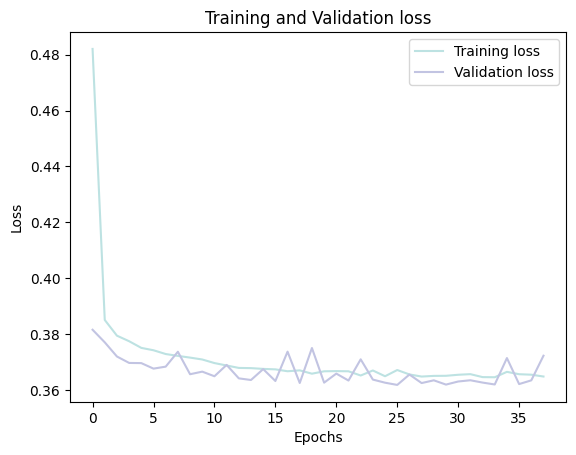

In [272]:
# Plotting training and validation loss over epochs
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

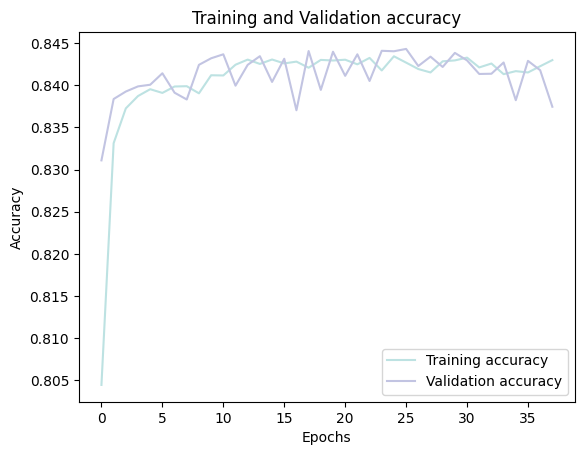

In [273]:
# Plotting training and validation accuracy over epochs
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## CONCLUSIONS

In [274]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     10527
           1       0.71      0.45      0.55      2822

    accuracy                           0.84     13349
   macro avg       0.79      0.70      0.73     13349
weighted avg       0.83      0.84      0.83     13349



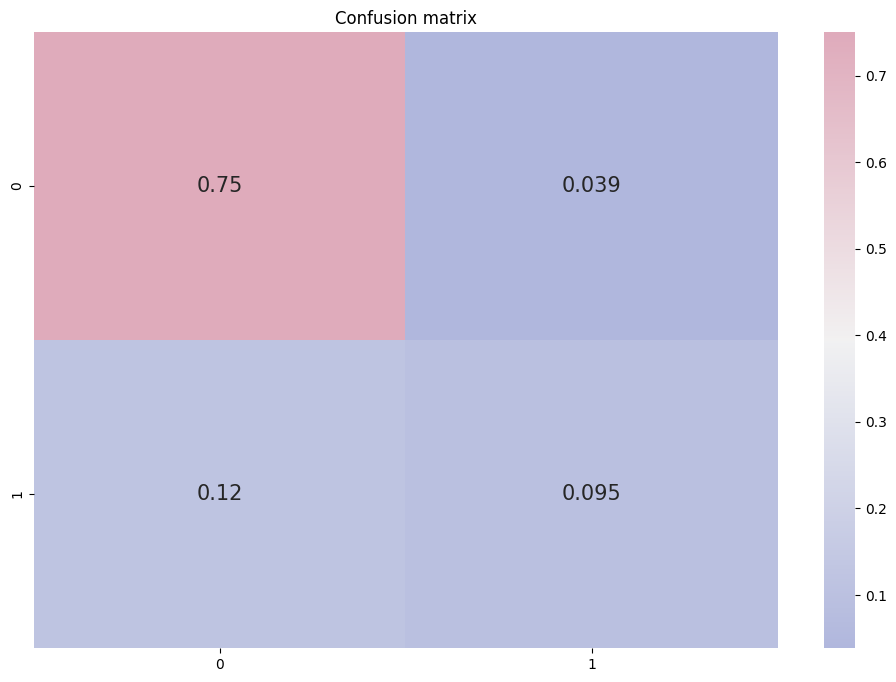

In [275]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
plt.title("Confusion matrix")

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})
print(classification_report(y_test, y_pred))